In [3]:
import glob
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Normalize, Resize, ToTensor


%matplotlib inline
warnings.filterwarnings("ignore")

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [4]:
device

'cpu'

In [7]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -qq kagglecatsanddogs_5340.zip
!rm -rf PerImages/Cat/666.jpg PetImagesy/Dog/11702.jpg readme\[1\].txt CDLA-Permissive-2.0.pdf

--2023-02-08 09:31:51--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.33.180.218, 2600:1408:20:c8b::317f, 2600:1408:20:c84::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.33.180.218|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip.2’

kagglecatsanddogs_5 100%[===================>] 786.67M   251MB/s    in 3.1s    

2023-02-08 09:31:54 (251 MB/s) - ‘kagglecatsanddogs_5340.zip.2’ saved [824887076/824887076]



In [8]:
dataset = ImageFolder(
    "./PetImages",
    transform=Compose(
        [
            Resize((224, 224)),
            ToTensor(),
            Normalize((0.5, 0.5, 0.5), (1, 1, 1)),
        ]
    )
)

train_set, val_set = torch.utils.data.random_split(
    dataset,
    [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))]
)

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=256, shuffle=False)

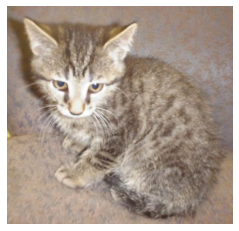

In [9]:
file = np.random.choice(glob.glob("./PetImages/*/*.jpg"))
plt.axis("off")
plt.imshow(plt.imread(file))

In [22]:
import pytorch_lightning as pl
from torchmetrics.functional import accuracy
from torchvision.models import resnet18

In [23]:
model = resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
class CatsVSDogsResnet():